# クラスタ分析

## k-means
k-meansのアルゴリズムについて見ていく。
k-meansの流れをざっくりと説明すると次のような手順となる。

1. 適当にクラスタの中心点（セントロイド）としてk点を設置する。
2. 全てのデータに対して、最も近いセントロイドのクラスタに割り当てる。
3. それぞれのクラスタで該当クラスタに属するデータの中心点を計算し、その点にセントロイドを移動する。
4. 2~3を収束するまで繰り返す。

k-meansは勿論scikit-learnに用意されている。使用例を以下に示す。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns

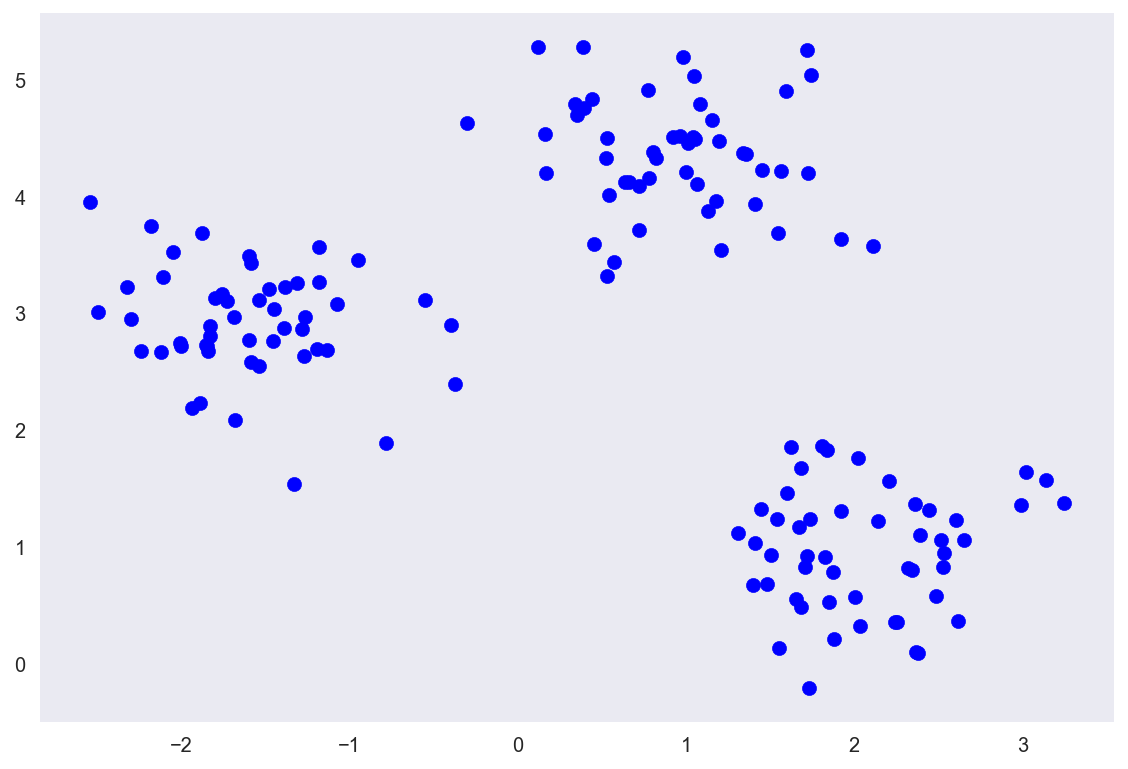

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', s=50)
plt.grid()
plt.tight_layout()
plt.show()

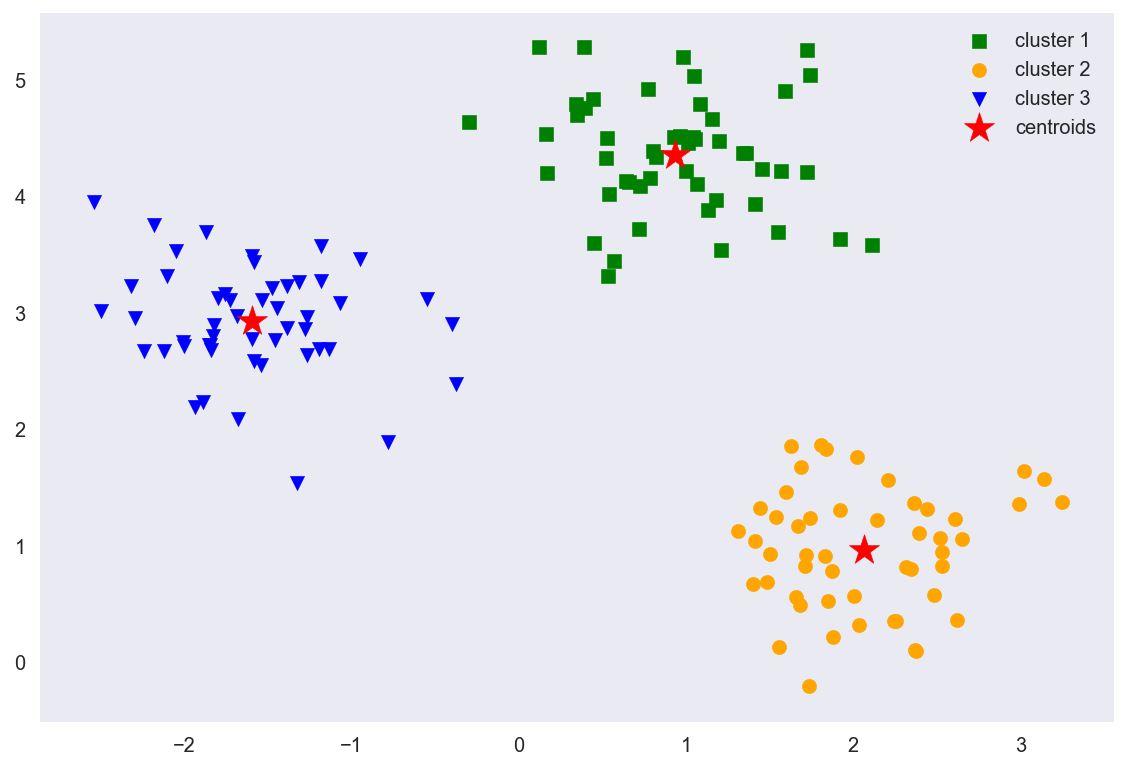

In [6]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, 
            init='random',
            n_init=10, # 異なるセントロイドの初期値を用いた実行回数
            max_iter=300, # 最大イテレーション回数
            tol=1e-04, # 収束判定のための相対的な許容誤差
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='green',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='blue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## k-meansの問題点
k-means法には、初期値の取り方によってクラスタリングが上手くいかないことや、収束に時間がかかってしまうという問題点がある。
その問題点は、上記のコードの様に複数の初期値でk-meansを実行することである程度回避ができる。
もう一つの解決策として、初期のセントロイドを互いに離れた場所に配置する、「k-means++」という方法がある。
scikit-learnでは、先程のk-meansのインスタンス作成の際に、引数を'random'の代わりに'k-means++'とすれば使用できる。

また、「あるクラスタに一つもデータが割り当てられない」という現象が起きることがある。これについては一応scikit-learnでの実装では対処しているようである。

最後の問題点として、クラスタ数が分からない時がある。これについてはクラスタ数も推定する「x-means」という方法がある。

## ハードクラスタリングとソフトクラスタリング
ハードクラスタリングは、サンプルが丁度一つのクラスタに割り当てられるアルゴリズムを指す。代表的な例としてはk-meansが挙げられる。
一方ソフトクラスタリングは、サンプルを一つ以上のクラスに割り当てるアルゴリズムを指す。代表的な例としてはFuzzy C-means(FCM)が挙げられる。

### FCM

FCM法はk-means法によく似ているが、以下の表のように各サンプルに対してそれぞれのクラスタに属する確率を出力する。

| クラス | 所属確率 |
|:------:|:-----------:|
| 1 | 0.10 |
| 2 | 0.85 |
| 3 | 0.05 |

各クラスの所属確率を合計すると1になる。

FCM法は一回のイテレーションでの計算コストが高いが、その代わり収束に必要なイテレーション回数が少ないという性質がある。
FCM法は残念ながらscikit-learnには実装されていないが、実際のクラスタリング結果はk-meansのものとよく似たものになるそう。

## エルボー法
エルボー法はクラスタの最適な個数を求める方法である。

ここで、エルボー法の説明に入る前にどのようにクラスタリング手法を評価すれば良いのかについて議論する。

クラスタリング手法は教師なし学習であるため、一般的な教師あり学習の評価手法が使えない。
その代わりにクラスタリングではクラス内SSE（歪み、慣性）を指標とする。実際に先程の結果に対して歪みを計算してみる。

In [7]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48



最適なクラスタ数を求める方法として、クラス内SSEはクラスタ数が増えれば増えるほど減っていくのは明らかである。そこで、kの値を減らして行き、それぞれのkの値に対して歪みを計算することで、急激に歪みが増える地点を探し出せれば、最適なkの数も分かるはずである。エルボー法はその考えを基にkを決定する。

下の例だと、kが3⇛2になったタイミングで急激に歪みが増えていることから、k=3と設定すれば良いことが分かる。

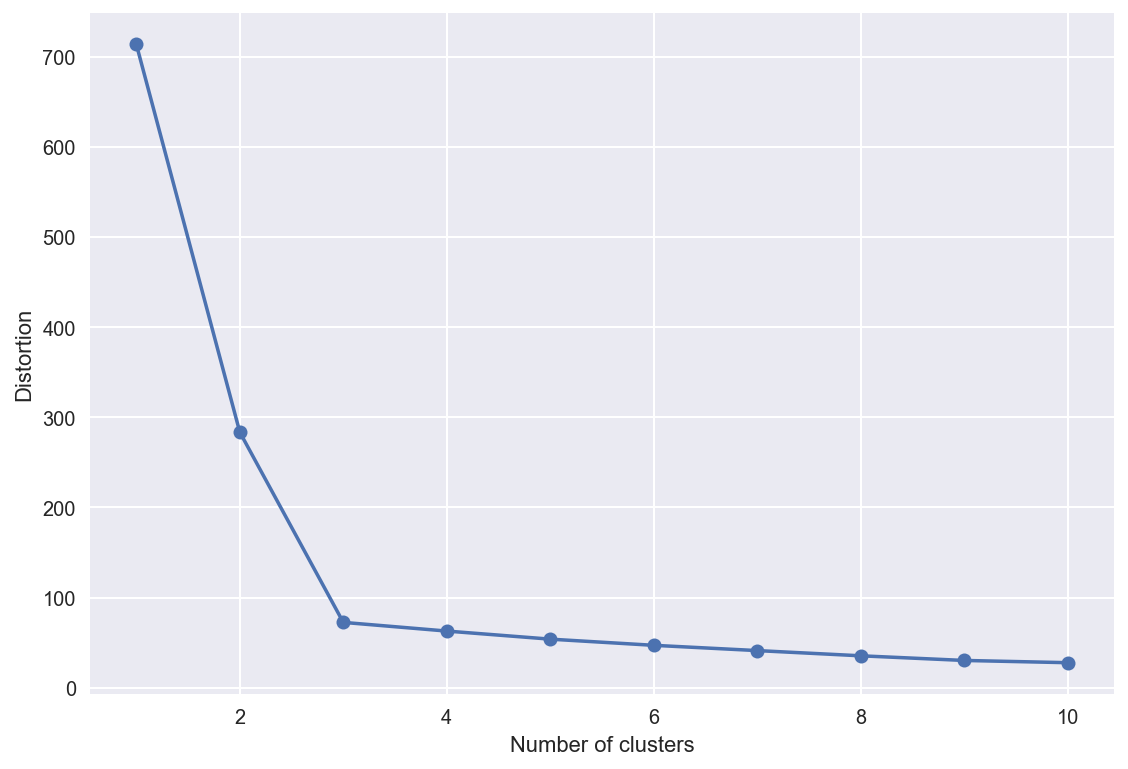

In [8]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

---
# シルエット分析
クラスタリングの性能評価をするための指標として、「シルエット分析」と呼ばれるものもある。
シルエット分析はk-means以外のクラスタ手法にも用いることが出来る。

シルエット係数はクラスタの密度を表していて、サンプル一つに対して一つずつ計算される。シルエット係数は凝集度と乖離度という数値を計算することで求められる, [-1, 1] の範囲の値を取る。1に近づくほど良いモデルであることを表している。
具体的な凝集度と乖離度の計算は次のように表される。

---

凝集度：あるサンプル $x_i$ と $x_i$ に属するクラスタの全てのサンプルとの距離の平均を計算し、それを凝集度 $a_i$とする。

乖離度：あるサンプル $x_i$ と $x_i$ が属するクラスタに最も近いクラスタの、全てのサンプルとの距離の平均を計算し、それを乖離度 $b_i$ とする。

---

後は、乖離度と凝集度の差分を取って、スケーリングしてあげればシルエット係数が求められる。

scikit-learnではmetricsモジュールに実装されている。使用例を示す。

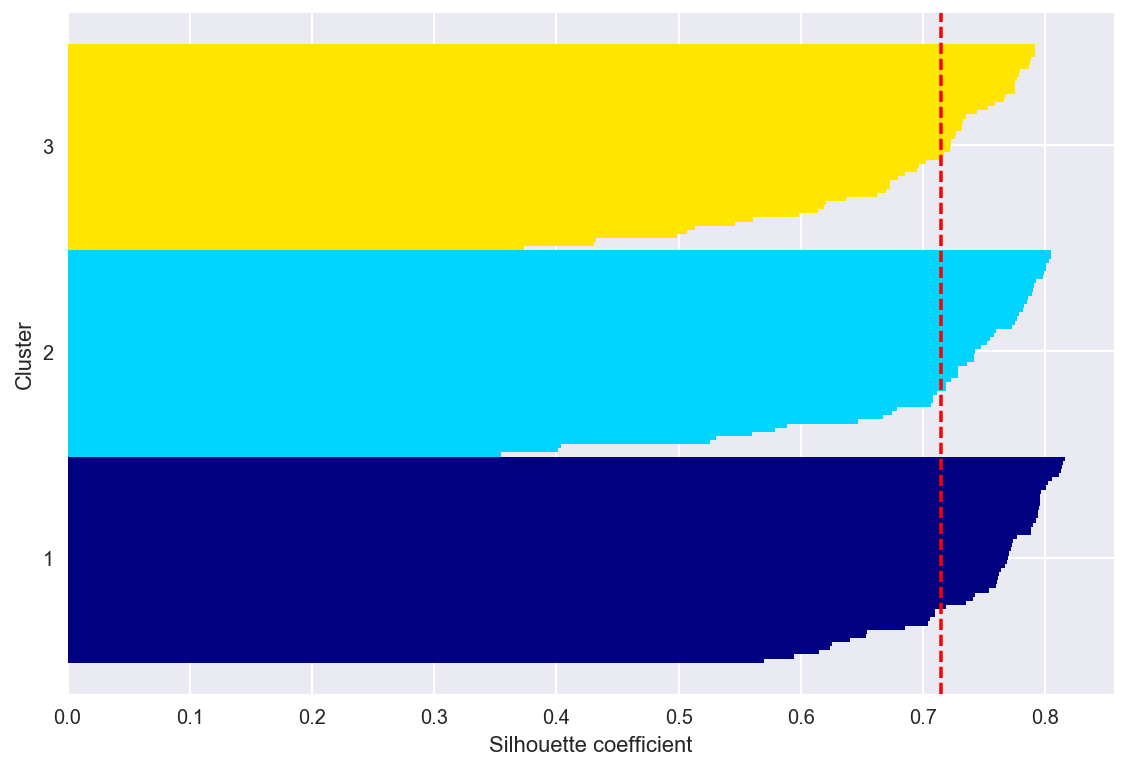

In [9]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

実行結果の出力として、シルエット図が出力されている。
クラスタ数は3つあり、サンプルがシルエット係数が高い順にソートされ並んでいる。
赤の点線は、全てのサンプルのシルエット係数を平均したものであり、1からは程遠いことが分かる。

次に、クラスタリングが上手く行ってないときの例として、クラスタ数を2にしたときについて調べてみる。セントロイドの数が2つでは、クラスタリングが上手く行かないことが図からも一目瞭然である。

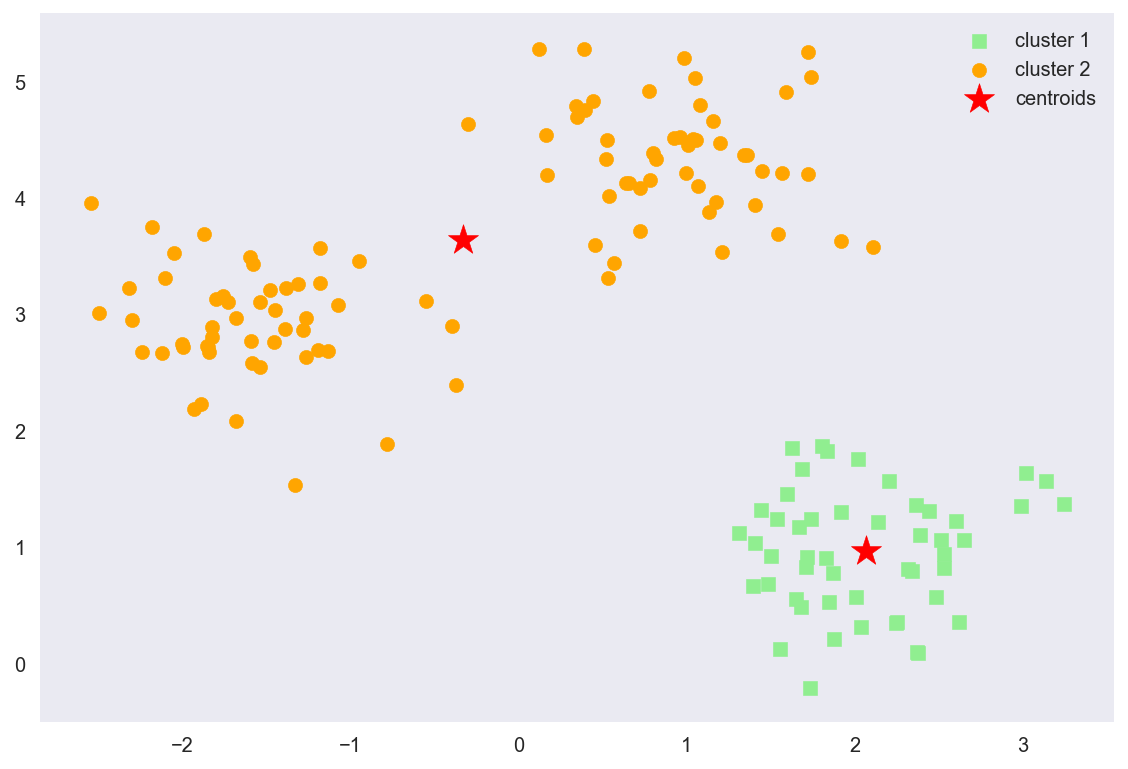

In [10]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

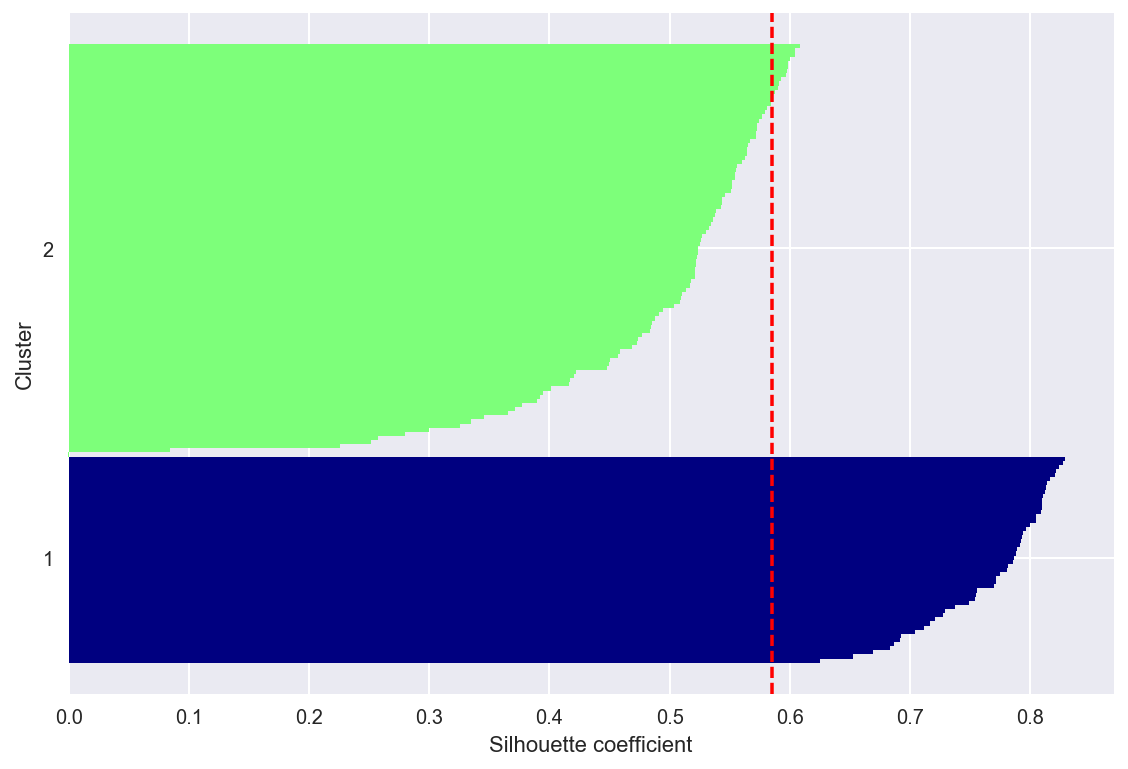

In [11]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

散布図からも分かる通り、クラスタ間で係数の値にかなり大きな乖離が見られる。このことから、シルエット図からも好ましくないクラスタリングが行われていることを伺える。

## 階層的クラスタリング

クラスタリング手法の一つである、階層的クラスタリングはクラスタリング結果を樹形図で表現出来る利点がある。
また、事前にクラスタ数を設定する必要もない。

階層的クラスタリングには分割型と凝集型がある。分割型は、最初に全てのサンプルを一つのクラスタとして、最後の一個になるまでクラスタを分割していくという方法である。凝集型は、全てのサンプル一つ一つをクラスタとみなし、近いものをマージすることでクラスタ数を絞っていく方法である。

例としてここでは完全連結法と言う、最も類似度が低いデータ点同士の関係に着目したクラスタリングに焦点を合わせる。

---
まずクラスタリングに用いるデータを与える。

In [12]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [ ]:
距離行列を計算する。

In [13]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [14]:
pdist(df, metric='euclidean')

array([ 4.973534  ,  5.51665266,  5.89988504,  3.83539555,  4.34707339,
        5.10431109,  6.69823298,  7.24426159,  8.31659367,  4.382864  ])

In [17]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


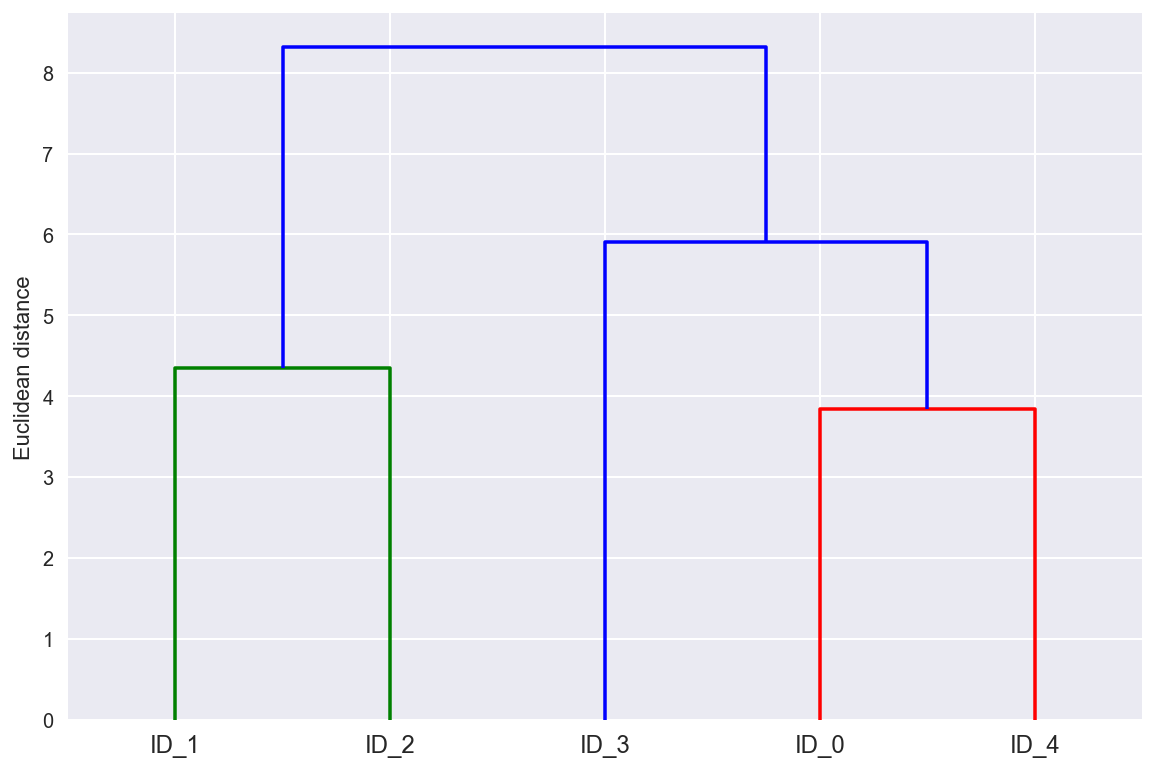

In [19]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

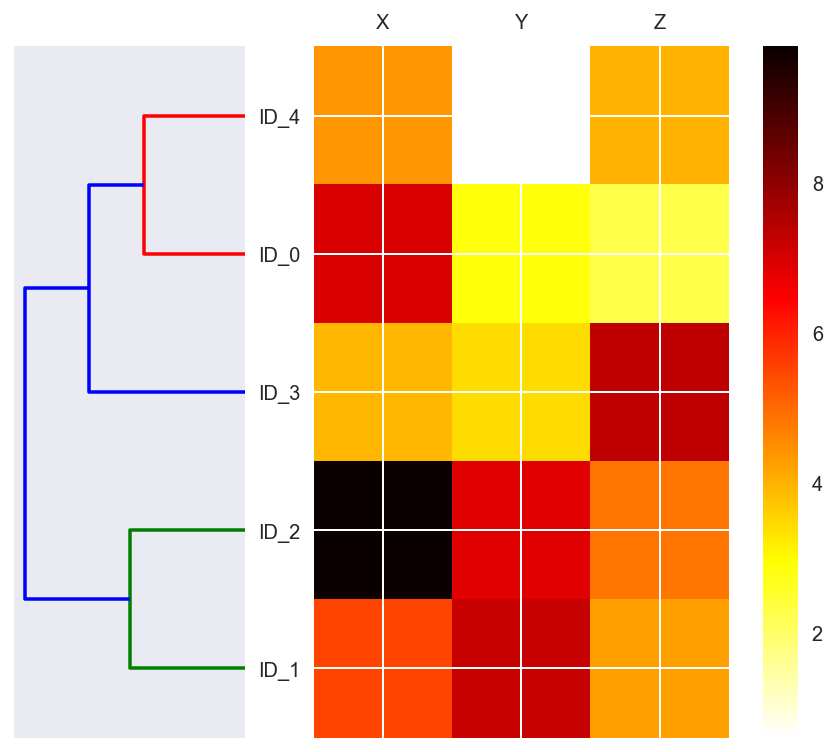

In [20]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# 樹形図を右に90度回転
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# 縦軸の目盛りを非表示
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

---
scikit-learnでも凝集階層クラスタリングが用意されている。
使用例と実行結果について以下に示す。クラスタ数を引数として与えることで、木の剪定と同様の処理をしてくれる。
アルゴリズムには上の例と同様、完全連結法を用いていて、実行結果が一致していることがわかる。

In [21]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


# DBSCAN

DBSCANもクラスタリング手法の一つで、高密度の領域を特定する手法になっている。
DBSCANでは以下の条件に基いて各サンプルに特別なラベルを割り当てる。

* コア点(Core point)：指定された半径ε以内に少なくとも指定された個数以上の隣接点を持つ点
* ボーダー点(Border point)：隣接点の個数が満たないものの、コア点の半径ε以内に位置している
* ノイズ点(Noise point)：二つの条件を両方とも満たしていない

ラベル割当後は、大まかに二つのステップでアルゴリズムは実行される。

1. コア点ごと、もしくはコア点の接続関係に基いて別々のクラスタを形成する。コア点同士が接続関係を持つのはそれらがεよりも離れていない場合とする。
1. 各ボーダー点を、それと対になっているコア点のクラスタに割り当てる。

DBSCANの利点の一つは、k-meansのように「クラスタが球状である」ということを前提としないこと、もう一つはノイズ点を定義することで、外れ値に対して無視が出来るということがある。

前者の利点について、各クラスタリング手法での半月状データののクラスタリング実験を通して確認する。

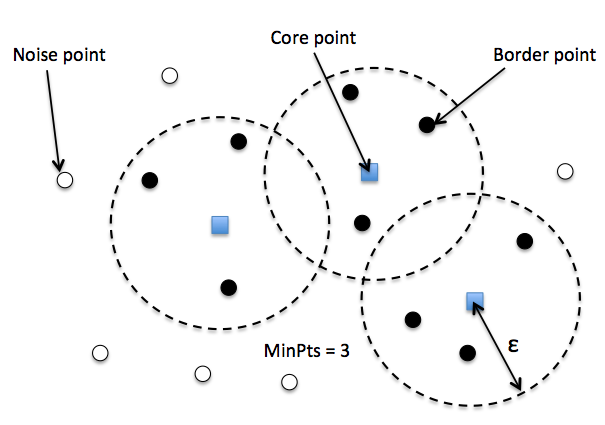

In [26]:
Image(filename='images/11_11.png', width=400)

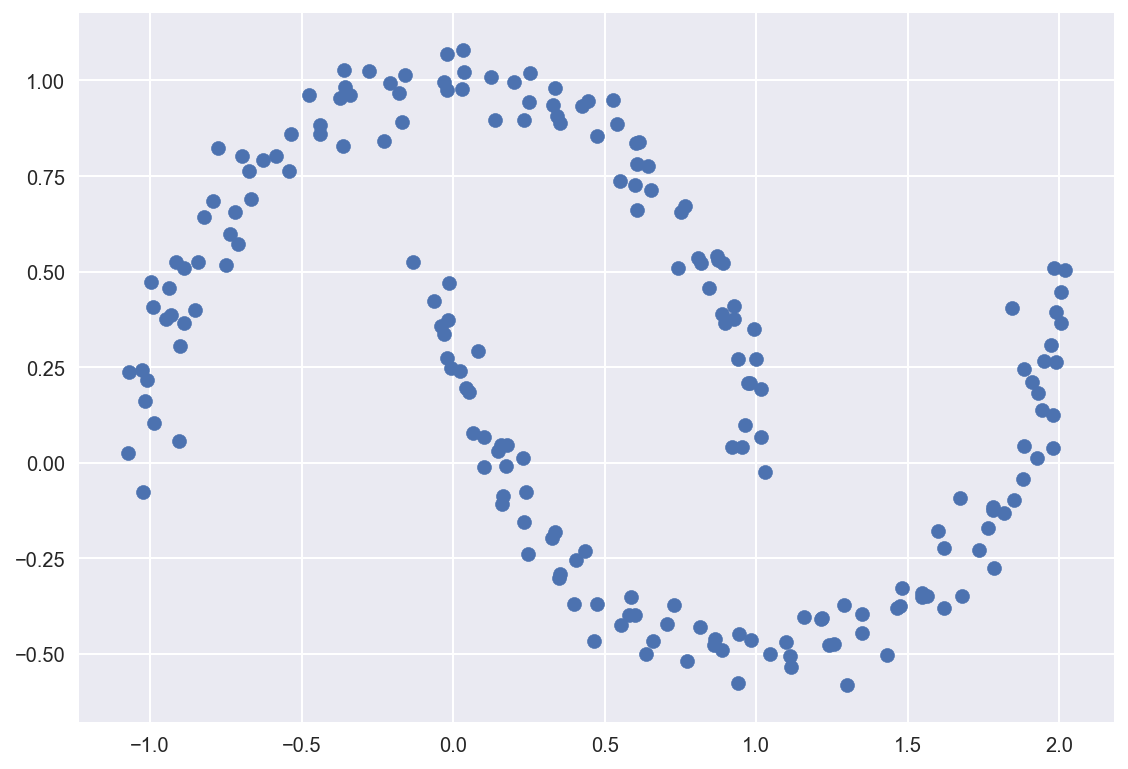

In [27]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

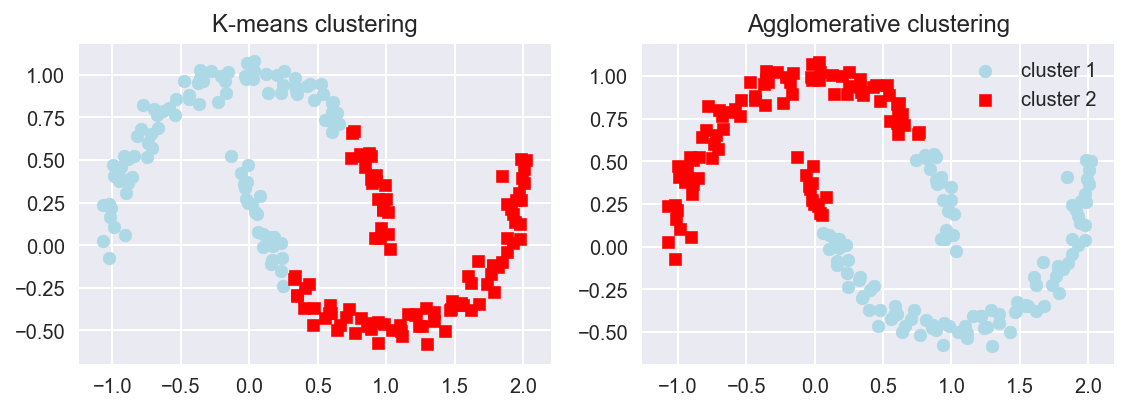

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

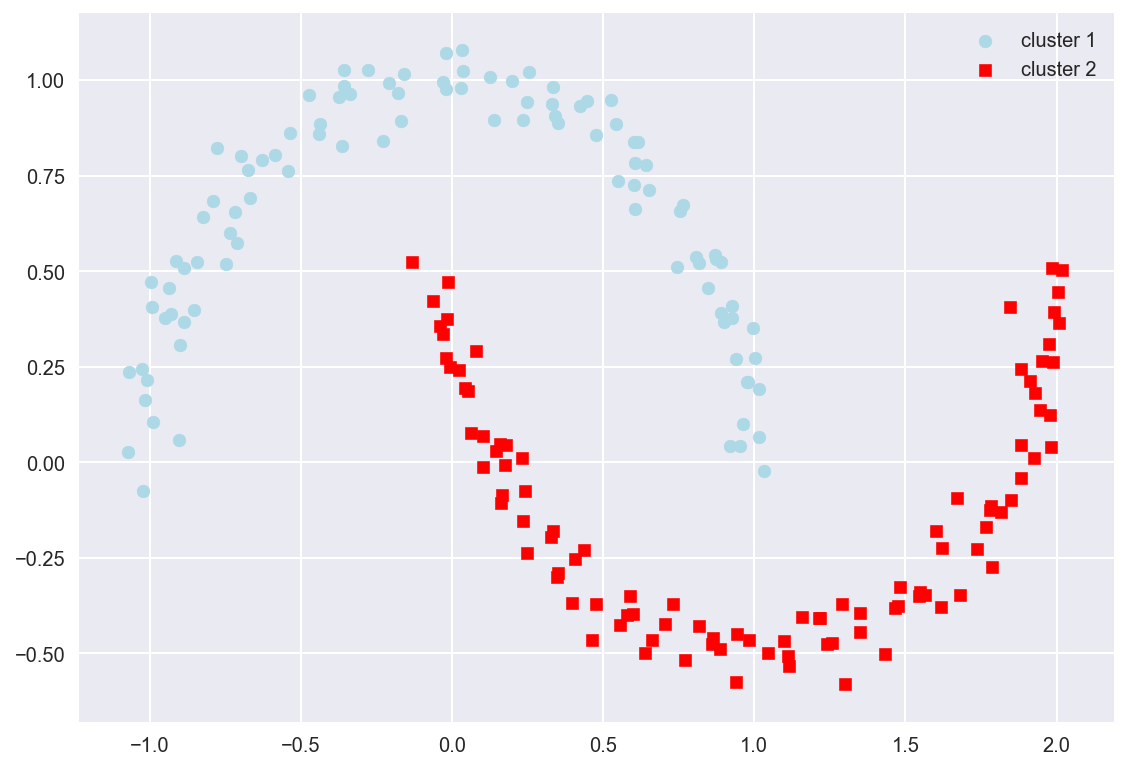

In [29]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

結果からDBSCANが任意の形状のクラスタリングを行うことが出来るということが分かった。
しかし、DBSCANにも欠点があり、εと最小個数という二つのハイパーパラメータを適切に選ばないと良い性能が出ない。

また、クラスタリング手法全般に言えることとして、ユークリッド距離を指標として使用する際に、特徴量の個数が増えると次元の呪いの影響をモロに受けてしまう。これに対処するにはPCAなどの次元削減手法を用いて対処が出来る。